# <center> Intrusion Detection 83% Accuracy Using SVM </center>

* [Data Overview](#overview)
    - [Data Reading](#read)
    - [Dataset Info](#info)
* [Data Cleaning](#clean)
    - [Column Renaming](#re)
    - [Binary Target Conversion](#bin)
    - [Categorical Encoding](#enc)
    - [Separating Target](#tar)
    - [Feature Scaling](#scale)
    - [Dimensionality Reduction](#red)
* [Modeling](#model)
    - [Linear Kernel](#lin)
    - [Polynomial Kernel](#poly)
    - [RBF Kernel](#rbf)
    - [Hyperparameter Tuning](#tun)
        - [Grid Search](#grid)
        - [Randomized Search](#random)
        - [Best Model Comparison](#compare)



In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import os  
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

sns.set_palette('dark')
sns.set_style('darkgrid')

## Data Overview <a id='overview'></a>

### Data Reading <a id='read'></a>

In [72]:
dataset_dir = '../../ml/dataset'

In [73]:

train_file = os.path.join(dataset_dir, 'KDDTrain+.txt')
test_file = os.path.join(dataset_dir, 'KDDTest+.txt')


In [74]:
train_file

'../../ml/dataset\\KDDTrain+.txt'

In [75]:
train = pd.read_csv(train_file,header=None)
test = pd.read_csv(test_file,header=None)
if train.shape[1] == 43:
    train = train.iloc[:, :-1]
    test = test.iloc[:, :-1]

train

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune


In [76]:
train.columns.tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41]

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       125973 non-null  int64  
 1   1       125973 non-null  object 
 2   2       125973 non-null  object 
 3   3       125973 non-null  object 
 4   4       125973 non-null  int64  
 5   5       125973 non-null  int64  
 6   6       125973 non-null  int64  
 7   7       125973 non-null  int64  
 8   8       125973 non-null  int64  
 9   9       125973 non-null  int64  
 10  10      125973 non-null  int64  
 11  11      125973 non-null  int64  
 12  12      125973 non-null  int64  
 13  13      125973 non-null  int64  
 14  14      125973 non-null  int64  
 15  15      125973 non-null  int64  
 16  16      125973 non-null  int64  
 17  17      125973 non-null  int64  
 18  18      125973 non-null  int64  
 19  19      125973 non-null  int64  
 20  20      125973 non-null  int64  
 21  21      12

### Dataset Info <a id='info'></a>

**Column names and values taken from the dataset description:**

**duration**: real

**protocol_type**: {'tcp','udp', 'icmp'} 

**service**: {'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'IRC', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois', 'X11', 'Z39_50'} 

**flag**: { 'OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH' }

**src_bytes**: real

**dst_bytes**: real

**land**: {'0', '1'}

**wrong_fragment**: real

**urgent**: real

**hot**: real

**num_failed_logins**: real

**logged_in**: {'0', '1'}

**num_compromised**: real

**root_shell**: real

**su_attempted**: real

**num_root**: real

**num_file_creations**: real

**num_shells**: real

**num_access_files**: real

**num_outbound_cmds**: real

**is_host_log**in**: {'0', '1'}

**is_guest_login**: {'0', '1'}

**count**: real

**srv_count**: real

**serror_rate**: real

**srv_serror_rate**: real

**rerror_rate**: real

**srv_rerror_rate**: real

**same_srv_rate**: real

**diff_srv_rate**: real

**srv_diff_host_rate**: real

**dst_host_count**: real

**dst_host_srv_count**: real

**dst_host_same_srv_rate**: real

**dst_host_diff_srv_rate**: real

**dst_host_same_src_port_rate**: real

**dst_host_srv_diff_host_rate**: real

**dst_host_serror_rate**: real

**dst_host_srv_serror_rate**: real

**dst_host_rerror_rate**: real

**dst_host_srv_rerror_rate**: real

<font color='green'> **class**: {'normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'} </font>

Column names need to be replaced, since they are inconsistent and uninformative. Moreover, Our goal is intrusion detection. Therefore the class feature should be binary. We do not care about the type of intrusion so all types will be labeled the same, while "normal" will be labeled differently. 

Since our goal is to fit an SVM to the data, we need to scale it in order to not create bias. We also need to reduce the number of features using PCA to avoid the curse of dimensionality.

## Data Cleaning <a id='cleaning'></a>

### Column Renaming <a id='re'></a>

In [78]:
columns = ['duration', 'protocol_type', 'service', 'flag',
           'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in',
           'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells',
           'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate',
           'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
           'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'class']

In [79]:
train.columns = columns
test.columns = columns

train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


### Binary Target Conversion <a id='bin'></a>

In [80]:
train['class'].unique()


array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [81]:
train['class'] = (train['class'] != "normal") * 1.0
test['class'] = (test['class'] != "normal") * 1.0

train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0.0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1.0
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0.0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,1.0
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.0
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0.0
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1.0


### Categorical Encoding <a id='enc'></a>

In [82]:
categorical = ['protocol_type', 'service', 'flag']

for cat in categorical:
    print(cat, "train:", train[cat].unique(),"\n\n", cat, "test:", test[cat].unique(),
          "\n\n============================================\n")

protocol_type train: ['tcp' 'udp' 'icmp'] 

 protocol_type test: ['tcp' 'icmp' 'udp'] 


service train: ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest'] 

 service test: ['private' 'ftp_data' 'eco_i' 'telnet' 'http' 'smtp' 'ftp' 'ldap' 'pop_3'
 'courier' 'discard' 'ecr_i' 'imap4' 'domain_u' 'mtp' 'systat' 'iso_tsap'
 'other' 'csnet_ns' 'finger' 'uucp' 'whois' 'netbios_ns' 'link' 'Z39_50'
 'sunrpc' 'auth' 'netbios_dgm' 'uucp_p

In [83]:
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0.0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1.0
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0.0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,1.0
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.0
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0.0
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1.0


### Starting Data
train:
attack_type	protocol	flag
normal	tcp	SF
attack	udp	REJ
test:
attack_type	protocol	flag
normal	tcp	SF
attack	tcp	SF
categorical = ['protocol', 'flag']
### Step 1: Combine with indicator
```python
whole = pd.concat([test.assign(ind="test"), train.assign(ind="train")])
```

whole:
attack_type	protocol	flag	ind
normal	tcp	SF	test
attack	tcp	SF	test
normal	tcp	SF	train
attack	udp	REJ	train
### Step 2: Loop iteration 1 - Process 'protocol'
```python

col = 'protocol'
one_hot = pd.get_dummies(whole[col], drop_first=True)
```
one_hot:
udp
0
0
0
1
(Note: drop_first=True drops 'tcp', keeps only 'udp')
```python
whole = whole.drop(columns=[col])
```

whole:
attack_type	flag	ind
normal	SF	test
attack	SF	test
normal	SF	train
attack	REJ	train
whole = pd.concat([whole, one_hot], axis=1)
whole:
attack_type	flag	ind	udp
normal	SF	test	0
attack	SF	test	0
normal	SF	train	0
attack	REJ	train	1
### Step 3: Loop iteration 2 - Process 'flag'
```python
col = 'flag'
one_hot = pd.get_dummies(whole[col], drop_first=True)
```
one_hot:
SF
1
1
1
0
(Note: drop_first=True drops 'REJ', keeps only 'SF')
```python
whole = whole.drop(columns=[col])
whole = pd.concat([whole, one_hot], axis=1)
```

whole:
attack_type	ind	udp	SF
normal	test	0	1
attack	test	0	1
normal	train	0	1
attack	train	1	0
### Step 4: Split back into test and train

```python

test = whole[whole["ind"].eq("test")].drop(columns="ind")
``` 
test:
attack_type	udp	SF
normal	0	1
attack	0	1
```python

train = whole[whole["ind"].eq("train")].drop(columns="ind")
```

train:
attack_type	udp	SF
normal	0	1
attack	1	0


Format sao ko vo column

In [84]:
whole = pd.concat([test.assign(ind="test"), train.assign(ind="train")])
for col in categorical:
    one_hot = pd.get_dummies(whole[col], drop_first=True)
    whole = whole.drop(columns=[col])
    whole = pd.concat([whole, one_hot],axis=1)
    

test, train = whole[whole["ind"].eq("test")].drop(columns="ind"),\
whole[whole["ind"].eq("train")].drop(columns="ind")

In [101]:
df = pd.DataFrame({'cost': [250, 150, 100],
                   'revenue': [100, 250, 300]},
                  index=['A', 'B', 'C'])
df

,cost,revenue
A,250,100
B,150,250
C,100,300


### Separating Target <a id='tar'></a>

In [85]:
y_train, y_test = train['class'], test['class']
X_train, X_test = train.drop(columns=['class']), test.drop(columns=['class'])

### Feature Scaling <a id='scale'></a>

In [86]:
ss = MinMaxScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### Dimensionality Reduction <a id='red'></a>

In [87]:
pca = PCA()
pca.fit(X_train)

explained_variance = pd.Series(pca.explained_variance_ratio_).apply(lambda x: '%.15f' % x)
explained_variance.values

array(['0.418402811158854', '0.158829107617731', '0.108077949651497',
       '0.048872752436783', '0.039455788928741', '0.028392294992589',
       '0.021492206766238', '0.017099611890237', '0.015047832877955',
       '0.013755111451038', '0.011502089824619', '0.009596362616027',
       '0.006856188809859', '0.006645805651301', '0.006056187364891',
       '0.005477923649905', '0.004571907225068', '0.004111899472262',
       '0.003834736877562', '0.003446431124114', '0.003326827996783',
       '0.002910900804508', '0.002343555103789', '0.002195681596462',
       '0.002094937920014', '0.001852376284956', '0.001717460817454',
       '0.001691910295249', '0.001597715409997', '0.001433741732116',
       '0.001390166178590', '0.001348552026754', '0.001341292597069',
       '0.001315601158431', '0.001308302507204', '0.001298827244496',
       '0.001265530114736', '0.001218213001788', '0.001197547959405',
       '0.001179081536961', '0.001158852584328', '0.001140280564114',
       '0.0011220742

We can see that we do not need more than 3 components to explain most of the variance. So let's use 3 features and reduce the training and testing sets.

In [88]:
pca = PCA(n_components=12)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## Modeling <a id='model'></a>

### Linear Kernel <a id='lin'></a>

In [89]:
lin = SVC(kernel='linear')
lin.fit(X_train, y_train)

y_pred = lin.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.92      0.75      9711
         1.0       0.91      0.60      0.72     12833

    accuracy                           0.74     22544
   macro avg       0.77      0.76      0.73     22544
weighted avg       0.79      0.74      0.73     22544



### Polynomial Kernel <a id='poly'></a>

In [90]:
poly = SVC(kernel='poly')
poly.fit(X_train, y_train)

y_pred = poly.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.93      0.76      9711
         1.0       0.92      0.62      0.74     12833

    accuracy                           0.75     22544
   macro avg       0.78      0.77      0.75     22544
weighted avg       0.80      0.75      0.75     22544



### RBF <a id='rbf'></a>

In [91]:
rbf = SVC(kernel='rbf')
rbf.fit(X_train, y_train)

y_pred = rbf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.93      0.76      9711
         1.0       0.92      0.62      0.74     12833

    accuracy                           0.75     22544
   macro avg       0.78      0.77      0.75     22544
weighted avg       0.80      0.75      0.75     22544



### Hyperparameter Tuning <a id='tun'></a>

We will only use a fraction of our dataset to speed up the search.

#### Grid Search <a id='grid'></a>

In [92]:
svm = SVC()
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

grid = GridSearchCV(svm,param_grid,refit = True)
grid.fit(X_train[:10000],y_train[:10000])

grid.best_params_

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

#### Random Search <a id='random'></a>

In [93]:
svm_dist1 = {
    "C": scipy.stats.expon(scale=.1),
    "gamma": scipy.stats.expon(scale=.01),
    "kernel": ["rbf"],
}

svm_dist2 = {
    "C": scipy.stats.expon(scale=1),
    "gamma": scipy.stats.expon(scale=.01),
    "kernel": ["rbf"],
}

svm_dist3 = {
    "C": scipy.stats.expon(scale=10),
    "gamma": scipy.stats.expon(scale=.01),
    "kernel": ["rbf"],
}

svm_dist4 = {
    "C": scipy.stats.expon(scale=100),
    "gamma": scipy.stats.expon(scale=.01),
    "kernel": ["rbf"],
}

svm_dist5 = {
    "C": scipy.stats.expon(scale=1000),
    "gamma": scipy.stats.expon(scale=.01),
    "kernel": ["rbf"],
}

svm_dist6 = {
    "C": scipy.stats.expon(scale=.1),
    "gamma": scipy.stats.expon(scale=1),
    "kernel": ["rbf"],
}

svm_dist7 = {
    "C": scipy.stats.expon(scale=1),
    "gamma": scipy.stats.expon(scale=1),
    "kernel": ["rbf"],
}

svm_dist8 = {
    "C": scipy.stats.expon(scale=10),
    "gamma": scipy.stats.expon(scale=1),
    "kernel": ["rbf"],
}

svm_dist9 = {
    "C": scipy.stats.expon(scale=100),
    "gamma": scipy.stats.expon(scale=1),
    "kernel": ["rbf"],
}

svm_dist10 = {
    "C": scipy.stats.expon(scale=1000),
    "gamma": scipy.stats.expon(scale=1),
    "kernel": ["rbf"],
}

svm_dist11 = {
    "C": scipy.stats.expon(scale=.1),
    "gamma": scipy.stats.expon(scale=10),
    "kernel": ["rbf"],
}

svm_dist12 = {
    "C": scipy.stats.expon(scale=1),
    "gamma": scipy.stats.expon(scale=10),
    "kernel": ["rbf"],
}

svm_dist13 = {
    "C": scipy.stats.expon(scale=10),
    "gamma": scipy.stats.expon(scale=10),
    "kernel": ["rbf"],
}

svm_dist14 = {
    "C": scipy.stats.expon(scale=100),
    "gamma": scipy.stats.expon(scale=10),
    "kernel": ["rbf"],
}

svm_dist15 = {
    "C": scipy.stats.expon(scale=1000),
    "gamma": scipy.stats.expon(scale=10),
    "kernel": ["rbf"],
}

svm_dist16 = {
    "C": scipy.stats.expon(scale=10),
    "degree": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "kernel": ["poly"],
}

distributions = [svm_dist1, svm_dist2, svm_dist3, svm_dist4, svm_dist5,
                svm_dist6, svm_dist7, svm_dist8, svm_dist9, svm_dist10,
                svm_dist11, svm_dist12, svm_dist13, svm_dist14, svm_dist15,
                svm_dist16]
clf = RandomizedSearchCV(svm, distributions, random_state=0, cv=5)

clf.fit(X_train[:10000], y_train[:10000])
clf.best_params_

{'C': 1044.6124955007756, 'gamma': 0.45924814117793333, 'kernel': 'rbf'}

#### Best Model Comparison <a id='compare'></a>

In [94]:
def show_auc(y, y_pred):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()

In [95]:
grid = SVC(C=1000, gamma=1, kernel='rbf')
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.97      0.81      9711
         1.0       0.97      0.68      0.80     12833

    accuracy                           0.81     22544
   macro avg       0.83      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544



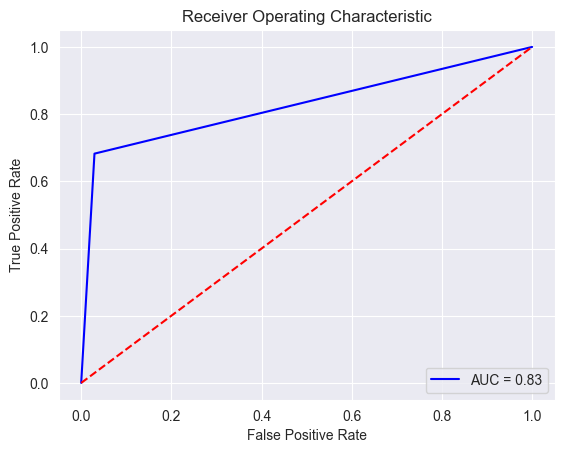

In [96]:
show_auc(y_test, y_pred)

In [97]:
rand = SVC(C=1044.612, gamma=0.459, kernel='rbf')
rand.fit(X_train, y_train)

y_pred = rand.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.93      0.81      9711
         1.0       0.93      0.72      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.82      0.82      0.81     22544
weighted avg       0.84      0.81      0.81     22544



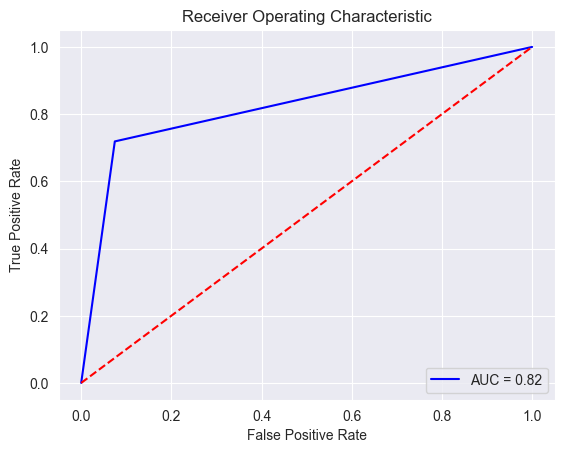

In [98]:
show_auc(y_test, y_pred)

As seen, the grid search model yields better accuracy but with worse precision and recall. A more balanced model is the random search model with better F1 score.

In [99]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = rand.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.93      0.81      9711
         1.0       0.93      0.72      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.82      0.82      0.81     22544
weighted avg       0.84      0.81      0.81     22544



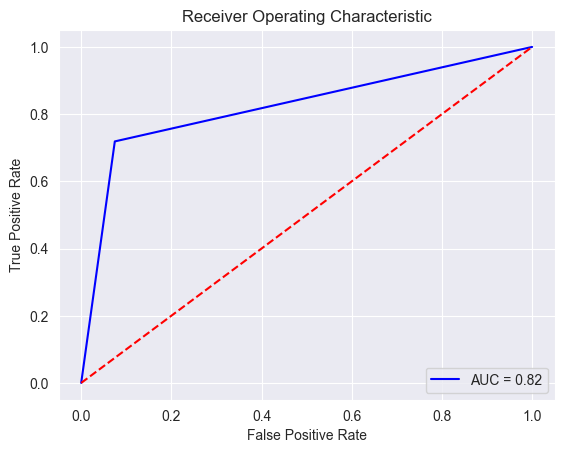

In [100]:
show_auc(y_test, y_pred)